<a href="https://colab.research.google.com/github/luisespriella9/AI-DeepLearning-Course/blob/master/RNN_Stock_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import separate files by copy paste since we will be using Google Research Colab To run this notebook

In [1]:
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

class AISP:
  def __init__(self, timesteps):
    self.train_dataset = None
    self.x_train = None
    self.timesteps = timesteps
    self.n_inputs = None
    self.scaler = None

  def build_train_data(self, company, train_start_date, train_end_date):
    # build dataframe
    train_dataset = self.build_dataset(company, train_start_date, train_end_date)
    self.n_inputs = len(train_dataset.columns)
    self.train_dataset = train_dataset

    # convert to numpy
    training_set = train_dataset.iloc[:, :].values

    # scale data
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_training_set = scaler.fit_transform(training_set)
    self.scaler = scaler

    # build train data
    x_train = []
    y_train = []
    for i in range(self.timesteps, len(scaled_training_set)):
        x_train.append(scaled_training_set[i-self.timesteps:i, :])
        y_train.append(scaled_training_set[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)

    # reshape data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], self.n_inputs))
    self.x_train = x_train

    return x_train, y_train

  def build_prediction_data(self, company, test_start_date, test_end_date):
      test_dataset = self.build_dataset(company, test_start_date, test_end_date)

      #concatenate with training data
      dataset_total = pd.concat((self.train_dataset, test_dataset), axis = 0)
      # dataset_total = dataset_total.fillna(method='ffill')
      # dataset_total = dataset_total.fillna(method='bfill')

      # minimize data to timesteps size
      inputs = dataset_total[len(dataset_total)-len(test_dataset)-self.timesteps:].values
      inputs = inputs.reshape(-1, 1) #set to right format
      #scale inputs
      inputs = self.scaler.transform(inputs)

      # build prediction data
      x_prediction = []
      for i in range(self.timesteps, self.timesteps+len(test_dataset)):
          x_prediction.append(inputs[i-self.timesteps:i, :])

      x_prediction = np.array(x_prediction)
      x_prediction = np.reshape(x_prediction, (x_prediction.shape[0], x_prediction.shape[1], self.n_inputs))
      return x_prediction

  def build_dataset(self, company, start_date, end_date):
    dataset = web.DataReader(company, "yahoo", start_date, end_date)[['Close']]
    # dataset = dataset.drop(['Volume'], axis=1)
    # inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred', start_date, end_date)
    # dataset = dataset.join(inflation)
    # dataset = dataset.fillna(method='ffill')
    # dataset = dataset.fillna(method='bfill')
    # gdp = web.DataReader('GDP', 'fred', start_date, end_date)
    # dataset = dataset.join(gdp)
    # dataset = dataset.fillna(method='ffill')
    # dataset = dataset.fillna(method='bfill')
    return dataset

  def inverse_transform(self, predicted_stock_price):
    y_scaler = MinMaxScaler()
    y_scaler.fit(self.train_dataset['Close'].values.reshape(-1, 1))
    return y_scaler.inverse_transform(predicted_stock_price)

  def build_rnn(self, n_inputs = None, units = 120, dropout_rate = 0.2, optimizer = 'adam', loss = 'mean_squared_error'):
    if (n_inputs == None):
      n_inputs = self.n_inputs
    regressor = Sequential()

    #add first LSTM layer and Dropout regularization
    first_lstm_layer = LSTM(units = units, return_sequences=True, input_shape = (self.x_train.shape[1], 1), )
    regressor.add(first_lstm_layer)

    dropout_layer = Dropout(rate = dropout_rate)
    regressor.add(dropout_layer)

    #Add 5 more LSTM Layers
    #second layer
    regressor.add(LSTM(units = units, return_sequences=True))
    regressor.add(Dropout(rate = dropout_rate))
    #third layer
    regressor.add(LSTM(units = units, return_sequences=True))
    regressor.add(Dropout(rate = dropout_rate))
    #fourth layer
    regressor.add(LSTM(units = units, return_sequences=True))
    regressor.add(Dropout(rate = dropout_rate))
    #fifth layer
    regressor.add(LSTM(units = units, return_sequences=True))
    regressor.add(Dropout(rate = dropout_rate))
    #sixth layer
    regressor.add(LSTM(units = units))
    regressor.add(Dropout(rate = dropout_rate))

    #add output layer
    output_layer = Dense(units = 1)
    regressor.add(output_layer)

    #compile RNN
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return regressor

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


# Select Company to Predict Data on

In [0]:
company = 'MU'
train_start_date = '1990-01-01'

# Validate Hyperparameters on Past Data to make sure rnn works well for specific stock

In [0]:
def validate(company, timesteps=120, units = 120, dropout_rate = 0.2, optimizer = 'rmsprop', loss = 'mean_squared_error', epochs=80, batch_size=32, train_start_date = '2010-01-01'):
  # create aisp class
  aisp = AISP(timesteps=timesteps)

  #Train RNN, Validate on two test sets
  current_date = datetime.now()
  current_date = current_date.replace(hour = 0, minute = 0, second=0, microsecond=0)
  test1_start_date = '2018-01-01'
  test1_end_date = '2018-02-01'
  test2_start_date = '2019-06-01'
  test2_end_date = '2019-07-01'
  test1_stock_values = aisp.build_dataset(company, test1_start_date, test1_end_date)['Close'].values
  test2_stock_values = aisp.build_dataset(company, test2_start_date, test2_end_date)['Close'].values


  # test 1
  x_train1, y_train1 = aisp.build_train_data(company, train_start_date, test1_start_date)
  x_test1 = aisp.build_prediction_data(company, test1_start_date, test1_end_date)

  # create rnn regressor
  regressor = aisp.build_rnn(units = units, dropout_rate = dropout_rate, optimizer = optimizer, loss = loss)

  regressor.fit(x_train1, y_train1, epochs=epochs, batch_size=batch_size)
  test1_predictions = regressor.predict(x_test1)
  test1_predictions = aisp.inverse_transform(test1_predictions)

  
  plt.plot(test1_stock_values, color='red', label='Real ' + str(company) +' Stock Price')
  plt.plot(test1_predictions, color='yellow', label='Predicted ' + str(company) +' Stock Price')
  plt.title(str(company) + ' Real Vs Predicted Stock Price Test 1')
  plt.xlabel('Time')
  plt.ylabel(str(company) + ' Stock Price Prediction')
  plt.legend()
  plt.show()

  # test 2
  x_train2, y_train2 = aisp.build_train_data(company, train_start_date, test2_start_date)
  x_test2 = aisp.build_prediction_data(company, test2_start_date, test2_end_date)

  # update rnn regressor
  regressor = aisp.build_rnn(units = units, dropout_rate = dropout_rate, optimizer = optimizer, loss = loss)

  regressor.fit(x_train2, y_train2, epochs=epochs, batch_size=batch_size)
  test2_predictions = regressor.predict(x_test2)
  test2_predictions = aisp.inverse_transform(test2_predictions)

  
  plt.plot(test2_stock_values, color='red', label='Real ' + str(company) +' Stock Price')
  plt.plot(test2_predictions, color='yellow', label='Predicted ' + str(company) +' Stock Price')
  plt.title(str(company) + ' Real Vs Predicted Stock Price Test 2')
  plt.xlabel('Time')
  plt.ylabel(str(company) + ' Stock Price Prediction')
  plt.legend()
  plt.show()

Epoch 1/15
6876/6876 [==============================] - 227s 33ms/step - loss: 0.0026
Epoch 2/15
6876/6876 [==============================] - 225s 33ms/step - loss: 0.0013
Epoch 3/15
6876/6876 [==============================] - 224s 33ms/step - loss: 0.0013
Epoch 4/15
6876/6876 [==============================] - 223s 32ms/step - loss: 8.8928e-04
Epoch 5/15
6876/6876 [==============================] - 222s 32ms/step - loss: 7.8978e-04
Epoch 6/15
6876/6876 [==============================] - 221s 32ms/step - loss: 7.7666e-04
Epoch 7/15
6876/6876 [==============================] - 221s 32ms/step - loss: 7.1719e-04
Epoch 8/15
6876/6876 [==============================] - 222s 32ms/step - loss: 5.9861e-04
Epoch 9/15
6876/6876 [==============================] - 221s 32ms/step - loss: 6.3565e-04
Epoch 10/15
6876/6876 [==============================] - 220s 32ms/step - loss: 5.0804e-04
Epoch 11/15
6876/6876 [==============================] - 220s 32ms/step - loss: 5.4953e-04
Epoch 12/15
6876/687

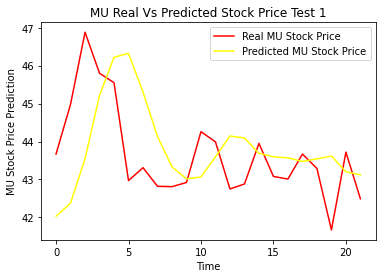

Epoch 1/15
7231/7231 [==============================] - 235s 33ms/step - loss: 0.0026
Epoch 2/15
7231/7231 [==============================] - 232s 32ms/step - loss: 0.0016
Epoch 3/15
7231/7231 [==============================] - 232s 32ms/step - loss: 0.0010
Epoch 4/15
7231/7231 [==============================] - 233s 32ms/step - loss: 9.1448e-04
Epoch 5/15
7231/7231 [==============================] - 232s 32ms/step - loss: 9.3604e-04
Epoch 6/15
7231/7231 [==============================] - 232s 32ms/step - loss: 7.7220e-04
Epoch 7/15
7231/7231 [==============================] - 231s 32ms/step - loss: 8.4440e-04
Epoch 8/15
7231/7231 [==============================] - 232s 32ms/step - loss: 6.8891e-04
Epoch 9/15
7231/7231 [==============================] - 234s 32ms/step - loss: 6.9497e-04
Epoch 10/15
7231/7231 [==============================] - 234s 32ms/step - loss: 5.7835e-04
Epoch 11/15
7231/7231 [==============================] - 234s 32ms/step - loss: 5.4103e-04
Epoch 12/15
7231/723

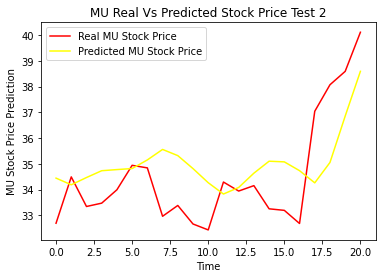

In [4]:
validate(company, timesteps=180, epochs=25, train_start_date = train_start_date)

# Predict Next Month Stock Price

In [0]:
def predict_next_month(company, timesteps=120, units = 120, dropout_rate = 0.2, optimizer = 'rmsprop', loss = 'mean_squared_error', epochs=60, batch_size=32, train_start_date = '2010-01-01'):
    # create aisp class
    aisp = AISP(timesteps=timesteps)

    # build data
    current_date = datetime.now()
    current_date = current_date.replace(hour = 0, minute = 0, second=0, microsecond=0)
    train_end_date = current_date-timedelta(days=1)
    prediction_end_date = current_date+timedelta(days=20)

    x_train, y_train = aisp.build_train_data(company, train_start_date, current_date)

    # create rnn regressor
    regressor = aisp.build_rnn(units = units, dropout_rate = dropout_rate, optimizer = optimizer, loss = loss)

    inputs = aisp.train_dataset.iloc[-aisp.timesteps:, :].values
    inputs = inputs.reshape(-1, 1) #set to right format

    inputs = aisp.scaler.transform(inputs)
    x_prediction = np.array([inputs])

    regressor.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

    predictions = []
    for i in range(20):
      prediction = regressor.predict(x_prediction)[0]
      predictions.append(prediction) # add new predicted value
      sample = x_prediction[0]
      sample = np.append(sample, prediction)
      sample = np.delete(sample, 0)
      sample = sample.reshape(x_prediction[0].shape)
      x_prediction[0] = sample

    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, 1)
    predictions = aisp.inverse_transform(predictions)

    plt.plot(predictions, color='yellow', label='Predicted ' + str(company) +' Stock Price')
    plt.title(str(company) + ' Predicted Stock Price for the next month')
    plt.xlabel('Time')
    plt.ylabel(str(company) + ' Stock Price Prediction')
    plt.legend()
    plt.show()

Epoch 1/25
7488/7488 [==============================] - 241s 32ms/step - loss: 0.0029
Epoch 2/25
7488/7488 [==============================] - 240s 32ms/step - loss: 0.0012
Epoch 3/25
7488/7488 [==============================] - 240s 32ms/step - loss: 0.0011
Epoch 4/25
7488/7488 [==============================] - 239s 32ms/step - loss: 9.4653e-04
Epoch 5/25
7488/7488 [==============================] - 240s 32ms/step - loss: 0.0011
Epoch 6/25
7488/7488 [==============================] - 239s 32ms/step - loss: 8.1798e-04
Epoch 7/25
7488/7488 [==============================] - 239s 32ms/step - loss: 7.3912e-04
Epoch 8/25
7488/7488 [==============================] - 240s 32ms/step - loss: 6.0432e-04
Epoch 9/25
7488/7488 [==============================] - 240s 32ms/step - loss: 7.0388e-04
Epoch 10/25
7488/7488 [==============================] - 239s 32ms/step - loss: 5.9082e-04
Epoch 11/25
7488/7488 [==============================] - 239s 32ms/step - loss: 5.6039e-04
Epoch 12/25
7488/7488 [=

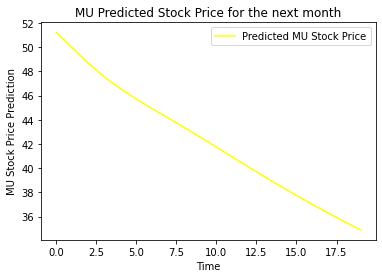

In [7]:
predict_next_month(company, timesteps=180, epochs = 25, train_start_date = train_start_date)

In [0]:
company = 'AMD'
train_start_date = '1990-01-01'

Epoch 1/25
6876/6876 [==============================] - 223s 32ms/step - loss: 0.0038
Epoch 2/25
6876/6876 [==============================] - 221s 32ms/step - loss: 0.0017
Epoch 3/25
6876/6876 [==============================] - 222s 32ms/step - loss: 0.0016
Epoch 4/25
6876/6876 [==============================] - 222s 32ms/step - loss: 0.0013
Epoch 5/25
6876/6876 [==============================] - 221s 32ms/step - loss: 0.0011
Epoch 6/25
6876/6876 [==============================] - 220s 32ms/step - loss: 9.7883e-04
Epoch 7/25
6876/6876 [==============================] - 221s 32ms/step - loss: 8.9334e-04
Epoch 8/25
6876/6876 [==============================] - 222s 32ms/step - loss: 8.5106e-04
Epoch 9/25
6876/6876 [==============================] - 220s 32ms/step - loss: 7.8859e-04
Epoch 10/25
6876/6876 [==============================] - 220s 32ms/step - loss: 6.9212e-04
Epoch 11/25
6876/6876 [==============================] - 219s 32ms/step - loss: 8.1035e-04
Epoch 12/25
6876/6876 [=====

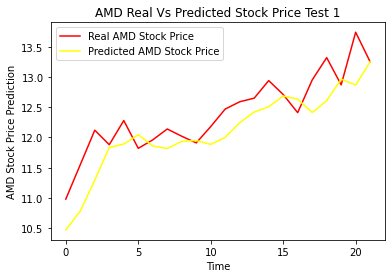

Epoch 1/25
7231/7231 [==============================] - 237s 33ms/step - loss: 0.0061
Epoch 2/25
7231/7231 [==============================] - 235s 33ms/step - loss: 0.0019
Epoch 3/25
7231/7231 [==============================] - 231s 32ms/step - loss: 0.0016
Epoch 4/25
7231/7231 [==============================] - 230s 32ms/step - loss: 0.0015
Epoch 5/25
7231/7231 [==============================] - 231s 32ms/step - loss: 0.0012
Epoch 6/25
7231/7231 [==============================] - 230s 32ms/step - loss: 0.0012
Epoch 7/25
7231/7231 [==============================] - 233s 32ms/step - loss: 0.0012
Epoch 8/25
7231/7231 [==============================] - 231s 32ms/step - loss: 0.0010
Epoch 9/25
7231/7231 [==============================] - 230s 32ms/step - loss: 8.7194e-04
Epoch 10/25
7231/7231 [==============================] - 233s 32ms/step - loss: 7.5778e-04
Epoch 11/25
7231/7231 [==============================] - 231s 32ms/step - loss: 7.3564e-04
Epoch 12/25
7231/7231 [=================

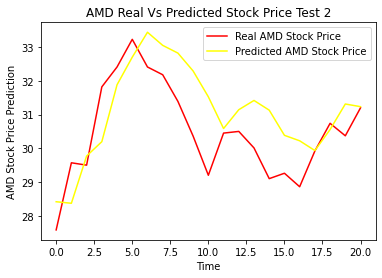

In [9]:
validate(company, timesteps=180, epochs=25, train_start_date = train_start_date)

Epoch 1/25
7488/7488 [==============================] - 243s 32ms/step - loss: 0.0042
Epoch 2/25
7488/7488 [==============================] - 240s 32ms/step - loss: 0.0016
Epoch 3/25
7488/7488 [==============================] - 240s 32ms/step - loss: 0.0014
Epoch 4/25
7488/7488 [==============================] - 240s 32ms/step - loss: 0.0010
Epoch 5/25
7488/7488 [==============================] - 241s 32ms/step - loss: 0.0011
Epoch 6/25
7488/7488 [==============================] - 240s 32ms/step - loss: 9.5784e-04
Epoch 7/25
7488/7488 [==============================] - 239s 32ms/step - loss: 8.2838e-04
Epoch 8/25
7488/7488 [==============================] - 239s 32ms/step - loss: 7.4622e-04
Epoch 9/25
7488/7488 [==============================] - 238s 32ms/step - loss: 7.3846e-04
Epoch 10/25
7488/7488 [==============================] - 239s 32ms/step - loss: 6.5144e-04
Epoch 11/25
7488/7488 [==============================] - 238s 32ms/step - loss: 6.6350e-04
Epoch 12/25
7488/7488 [=====

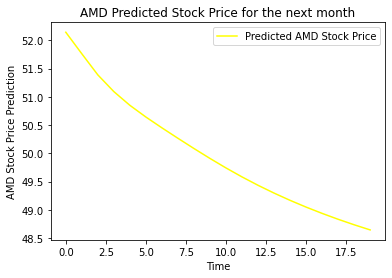

In [10]:
predict_next_month(company, timesteps=180, epochs=25, train_start_date = train_start_date)

In [0]:
company = 'NVDA'
train_start_date = '2000-01-01'

In [0]:
#validate(company, timesteps=180, epochs=60, train_start_date = train_start_date)

Epoch 1/25
4960/4960 [==============================] - 161s 33ms/step - loss: 0.0047
Epoch 2/25
4960/4960 [==============================] - 161s 32ms/step - loss: 0.0013
Epoch 3/25
4960/4960 [==============================] - 165s 33ms/step - loss: 0.0011
Epoch 4/25
4960/4960 [==============================] - 163s 33ms/step - loss: 0.0013
Epoch 5/25
4960/4960 [==============================] - 161s 32ms/step - loss: 0.0011
Epoch 6/25
4960/4960 [==============================] - 161s 33ms/step - loss: 0.0011
Epoch 7/25
4960/4960 [==============================] - 161s 32ms/step - loss: 9.7268e-04
Epoch 8/25
4960/4960 [==============================] - 159s 32ms/step - loss: 8.1630e-04
Epoch 9/25
4960/4960 [==============================] - 161s 32ms/step - loss: 8.8875e-04
Epoch 10/25
4960/4960 [==============================] - 162s 33ms/step - loss: 7.9693e-04
Epoch 11/25
4960/4960 [==============================] - 160s 32ms/step - loss: 7.5089e-04
Epoch 12/25
4960/4960 [=========

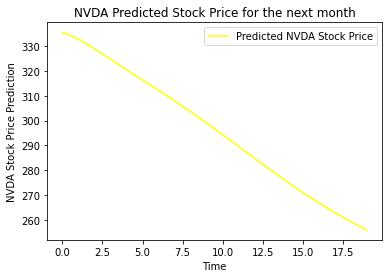

In [13]:
predict_next_month(company, timesteps=180, epochs=25, train_start_date = train_start_date)